# Check Spectrum calibration from Bouguer lines for FELH0600 date 2022/06/29


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 23th 2022
- update : September 23th 2022



** Kernel anaconda3_auxtel**




# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle

In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits',
 'thermtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [6]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack

In [7]:
# import libradtran
sys.path.append('../../../simulation/atmsim/libradtran')
import libsimulateVisible

libradtranpath= /Users/sylvie/MacOSX/External/libRadtran2/


In [8]:
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

In [84]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
oxygen_lines_order1 = Lines([O2_1,O2_2])

In [10]:
#ax.plot([x_O2_1,x_O2_1],[72,100],'b-',lw=3)
#ax.annotate(O2_1.label, xy=(x_O2_1, 80), color='b',fontsize=20,fontweight='bold')
    

# Functions

In [11]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [12]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [13]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [14]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    #correction_area = 1.06/1.13
    correction_area = 1
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]/ correction_area 
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]/ correction_area 
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [15]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    for key, value in dict_spectra.items():
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

# Constants

# Initialisation

In [16]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [17]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-09-26 13:43:45,516 imacdagoret.lal.in2p3.fr __main__[37221] INFO LA time:04:43:45
2022-09-26 13:43:45,520 imacdagoret.lal.in2p3.fr __main__[37221] INFO NY time:07:43:45
2022-09-26 13:43:45,524 imacdagoret.lal.in2p3.fr __main__[37221] INFO London time:12:43:45
2022-09-26 13:43:45,536 imacdagoret.lal.in2p3.fr __main__[37221] INFO Paris time:13:43:45
2022-09-26 13:43:45,537 imacdagoret.lal.in2p3.fr __main__[37221] INFO ************************ START *********************


In [18]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [19]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-holo-20220629-configPSF1D_FELH0600.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-09-26 13:43:45,546 imacdagoret.lal.in2p3.fr __main__[37221] INFO Configuration file : config/confprog_run-auxtel-holo-20220629-configPSF1D_FELH0600.ini


In [20]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2022-09-26 13:43:45,551 imacdagoret.lal.in2p3.fr __main__[37221] INFO 1) Configuration


In [21]:
config_section = config.sections()

In [22]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [23]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
   
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    
    MAGLIMMIN     = float(config['GENERAL']['MAGLIMMIN'])
    MAGLIMMAX     = float(config['GENERAL']['MAGLIMMAX'])
    FLUXLIMMIN    = float(config['GENERAL']['FLUXLIMMIN'])
    FLUXLIMMAX    = float(config['GENERAL']['FLUXLIMMAX'])

    
    
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    inputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    inputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [24]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2022-09-26 13:43:45,572 imacdagoret.lal.in2p3.fr __main__[37221] INFO  Object observed HD142331 at AUXTEL/Rubin Obs (2022-06-29)


In [25]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [26]:
list_of_badnums1 = [int(nn)  for nn in BADEXPOS.split()]
list_of_badnums1

[58, 88, 304, 305, 390, 418, 420, 451, 505]

In [27]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [28]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

Warning, 62 of 6262 bins contained negative fluxes; they have been set to zero.


In [29]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [30]:
# interpolation function
f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")

In [31]:
targetname = s0.fheader['TARGETID']

In [32]:
sed_m=-2.5*np.log10(sed_f)

Text(0, 0.5, 'mag')

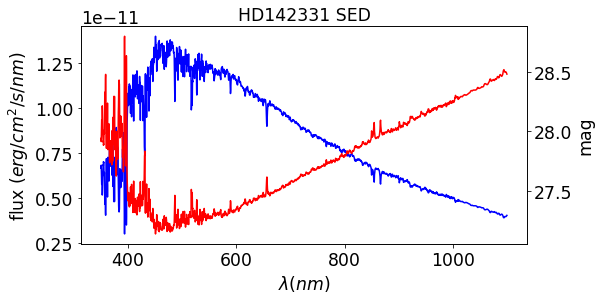

In [33]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,sed_f,'b')
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title(targetname + " SED")
ax2=ax.twinx()
ax2.plot(sed_w,sed_m,'r-')
ax2.set_ylabel("mag")

# Simulate the atmosphere

In [34]:
am       = 1.2
pressure = 0. # use default value
pwv      = 4.0
aer      = 0.1
ozone    = 300.
cloudext = 0

In [35]:
path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,prof_str='us',proc_str='sa',cloudext=cloudext)
data = np.loadtxt(os.path.join(path,thefile))
wl = data[:,0]
atm = data[:,1] 

Text(0.5, 1.0, 'atmospheric transmission')

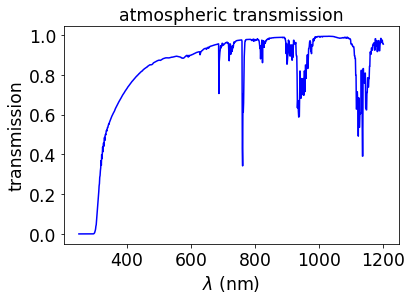

In [36]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(wl,atm,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_title("atmospheric transmission")

In [37]:
f_atm = interpolate.interp1d(wl,atm,bounds_error=False,fill_value="extrapolate")

# Throughputs

## Auxtel throughput and  telescope throughput

In [38]:
filename = "../../../simulation/throughputs/AuxTel-throughput.xlsx"

In [39]:
dft = pd.read_excel(filename,header=1,index_col=0)
dft.reset_index(inplace=True)
dft['index'] = dft.reset_index().index
dft.set_index('index')
dft.rename(columns={'lambda':'lambdas'},inplace = True)

Text(0.5, 1.0, 'auxtel throughput')

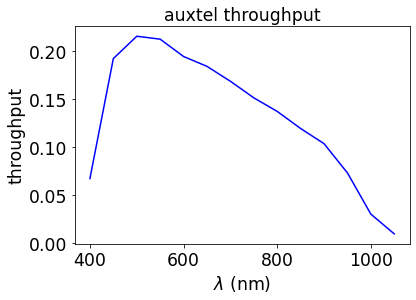

In [40]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(dft.lambdas,dft.throughput,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [41]:
# interpolation function
f_thr = interpolate.interp1d(dft.lambdas,dft.throughput,bounds_error=False,fill_value="extrapolate")

## Filter

In [42]:
filename = "../../../simulation/filters/FELH0600_Transmission.txt"

In [43]:
arr =  np.loadtxt(filename)

Text(0.5, 1.0, 'auxtel FELH600 throughput')

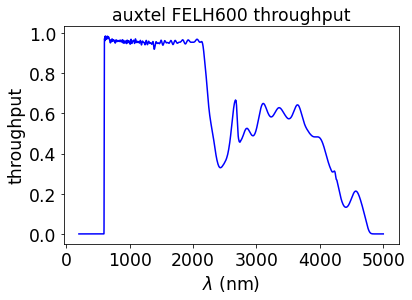

In [44]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(arr[:,0],arr[:,1],"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel FELH600 throughput")

In [45]:
f_filter_thr = interpolate.interp1d(arr[:,0],arr[:,1],bounds_error=False,fill_value="extrapolate")

## spectrum data

In [46]:
fullfilename=os.path.join(inputdir,inputfile)

In [47]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [48]:
NBSPECTRA=len(summary_content)

In [49]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2022-09-26 13:43:55,643 imacdagoret.lal.in2p3.fr __main__[37221] INFO  Number of selected files is 37


In [50]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [51]:
infos, all_spectra = GetSpectra(summary_content)

# Remove bad Spectra

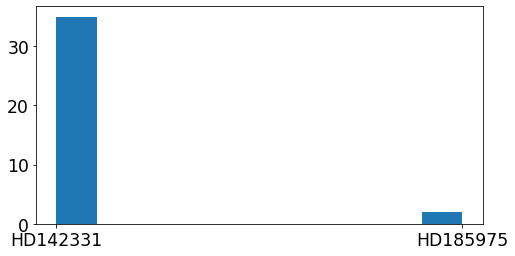

In [52]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);

Text(0.5, 0.98, 'Variables to apply selection')

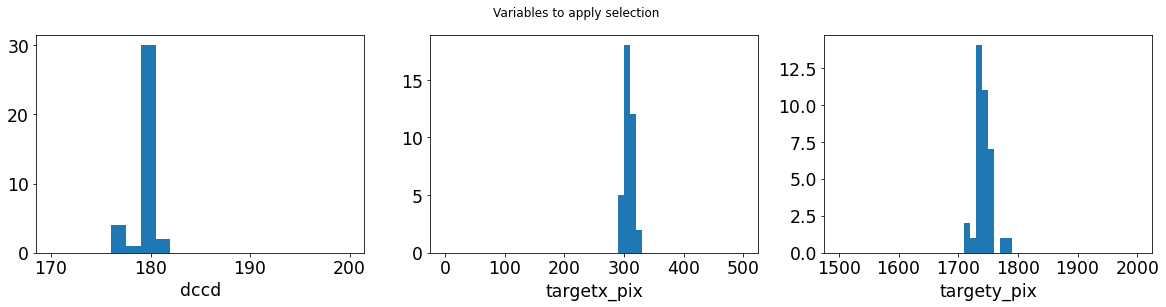

In [53]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.d2ccd,bins=20,range=(170,200));
ax.set_xlabel("dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.targetx_pix,bins=50,range=(0,500));
ax.set_xlabel("targetx_pix")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.targety_pix,bins=50,range=(1500,2000));
ax.set_xlabel("targety_pix")
plt.suptitle("Variables to apply selection")

## Define sepection cut

In [54]:
selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)
bad_cut = ~selection_cut

In [55]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

array([206, 363, 366, 390, 451, 505], dtype=object)

# Union of badnums

In [56]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums=np.unique(list_of_badnums)

# Filtered spectra

In [57]:
list_of_badnums

array([58, 88, 206, 304, 305, 363, 366, 390, 418, 420, 451, 505],
      dtype=object)

In [58]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 0 for exposure 58
Remove spectrum 2 for exposure 88
Remove spectrum 11 for exposure 206
Remove spectrum 16 for exposure 304
Remove spectrum 17 for exposure 305
Remove spectrum 20 for exposure 363
Remove spectrum 21 for exposure 366
Remove spectrum 22 for exposure 390
Remove spectrum 24 for exposure 418
Remove spectrum 26 for exposure 420
Remove spectrum 28 for exposure 451
Remove spectrum 34 for exposure 505


# Plot Spectra

In [59]:
NBSPECTRA=len(all_spectra)

In [60]:
assert NBSPECTRA == len(infos)

In [61]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [62]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-09-26 13:43:56,405 imacdagoret.lal.in2p3.fr __main__[37221] INFO  Number of good spectra is 25


### load absorption pattern

In [63]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

In [87]:
def plotlines(ax,ypos):
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

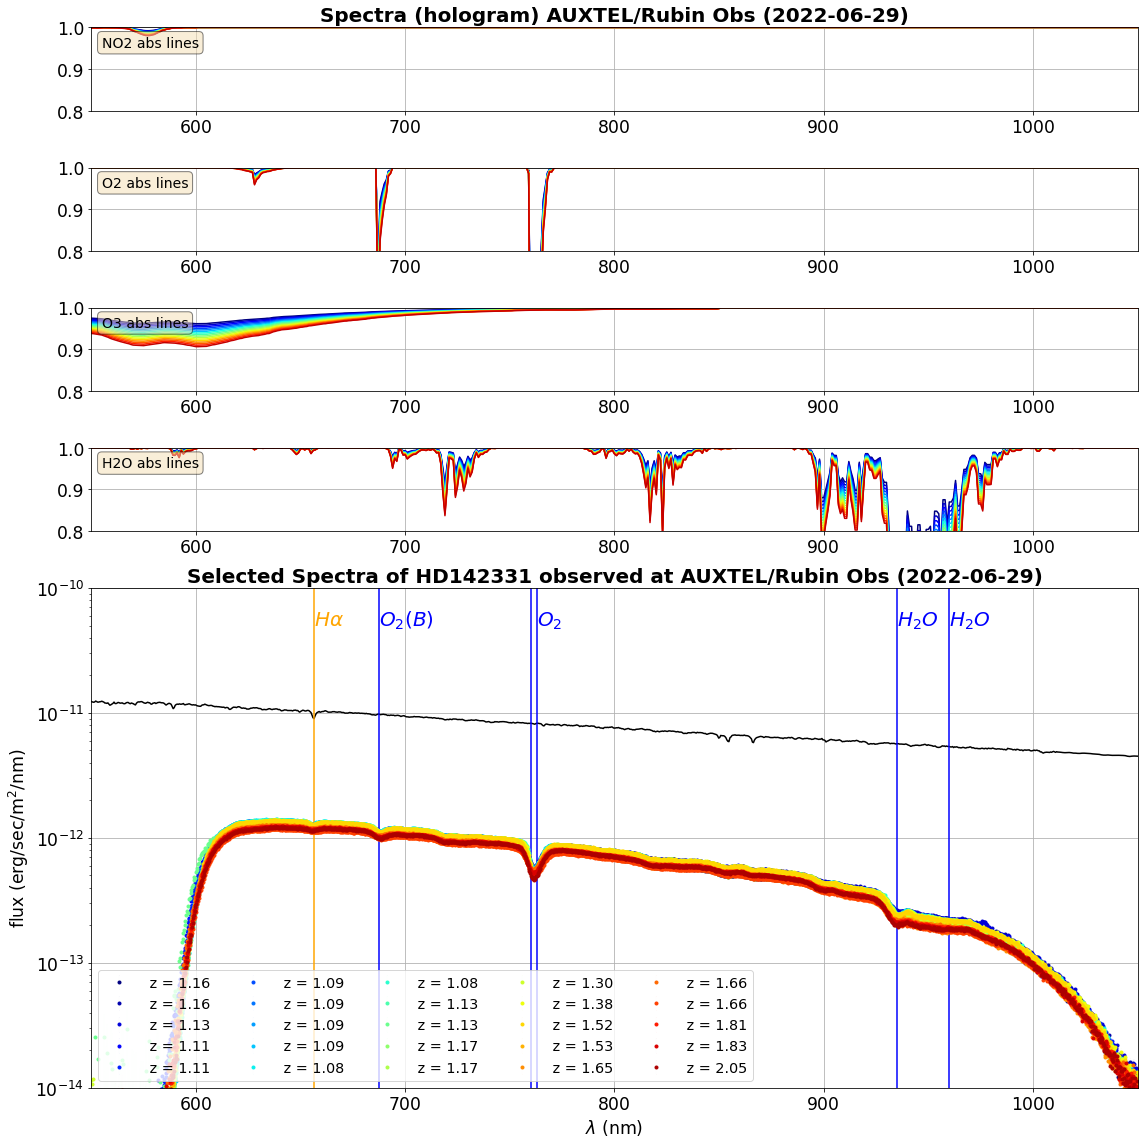

In [88]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)

# NO2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_title(title,fontsize=20,fontweight='bold')
main_ax = ax



# O2    
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)


# Ozone
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum
ax=fig.add_subplot(gs[4,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
#ax.set_ylim(1e-14,1e-10)
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=5)

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)




plt.tight_layout()


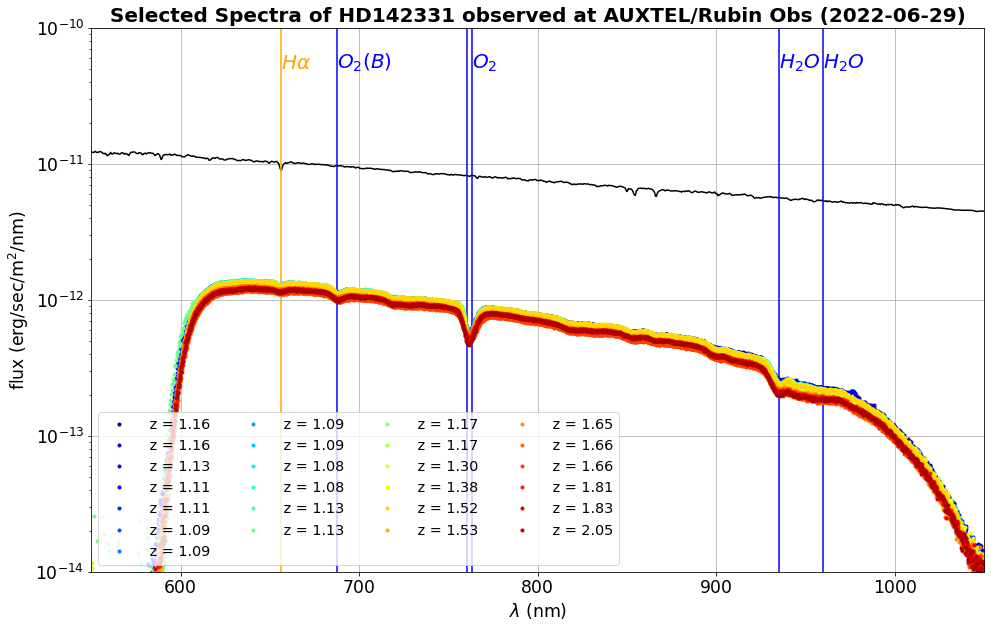

In [91]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=4)
#ax.legend(bbox_to_anchor=(1.02, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)


/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-pac

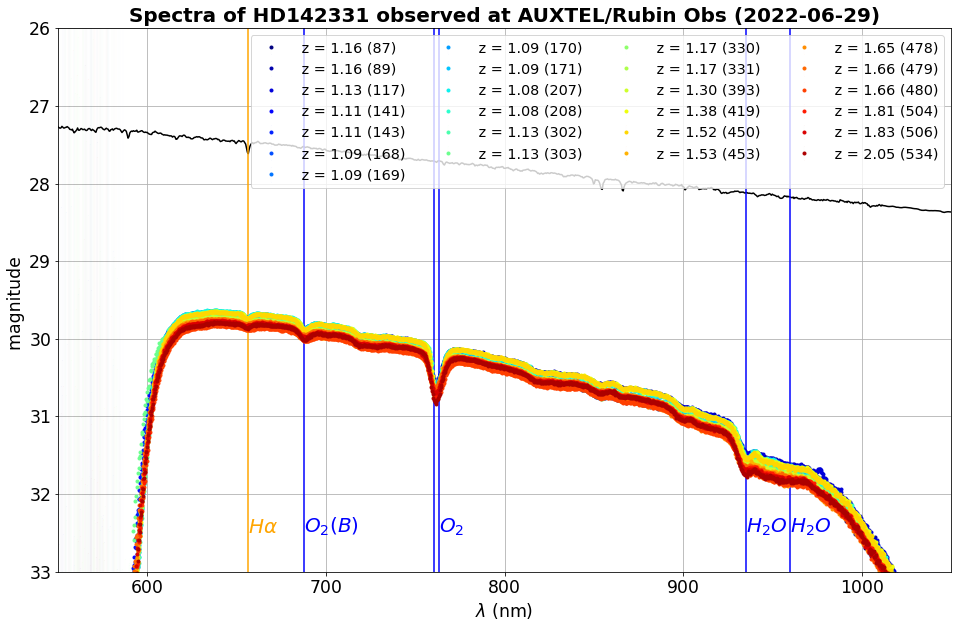

In [96]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=4)
#ax.legend(bbox_to_anchor=(1.02, 0))

# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)


/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-pac

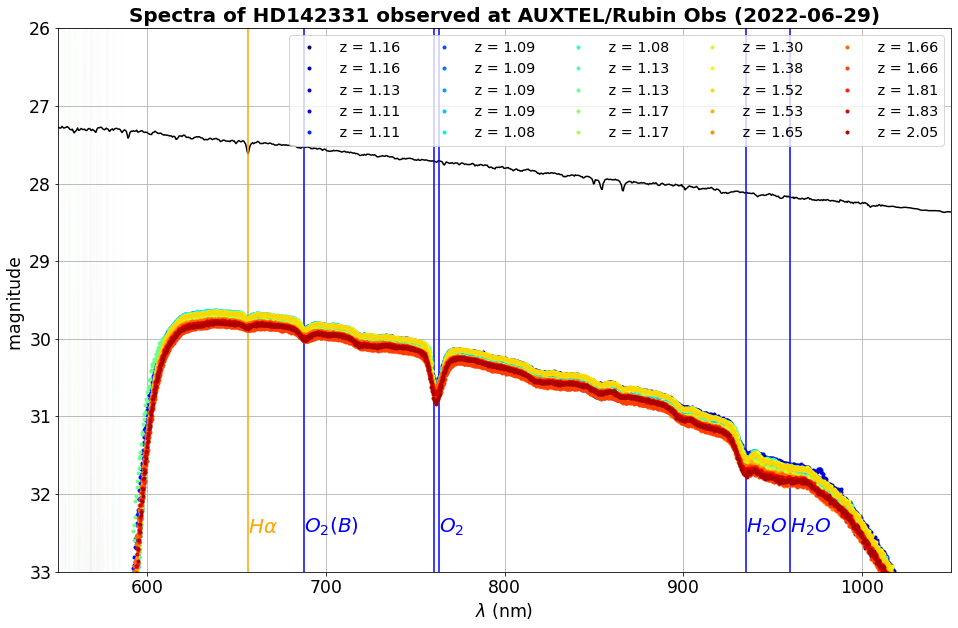

In [98]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0))
# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)

# Multiply SED by all throughput

In [99]:
correction_area = 1.06/1.13

In [100]:
sed_predicted_f = f_sed(WL) * f_thr(WL) * f_atm(WL) * f_filter_thr(WL)
sed_predicted_m = -2.5*np.log10(sed_predicted_f) 

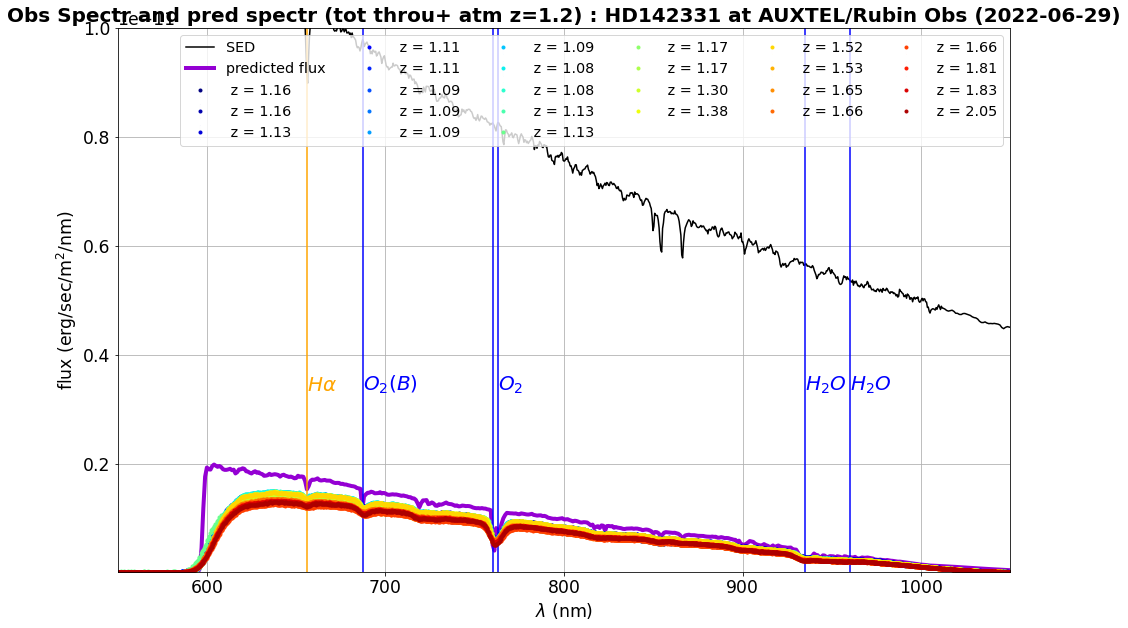

In [104]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Obs Spectr and pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX/10.)
#ax.set_yscale("log")
ax.legend(loc="upper right",ncol=6)


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/30)



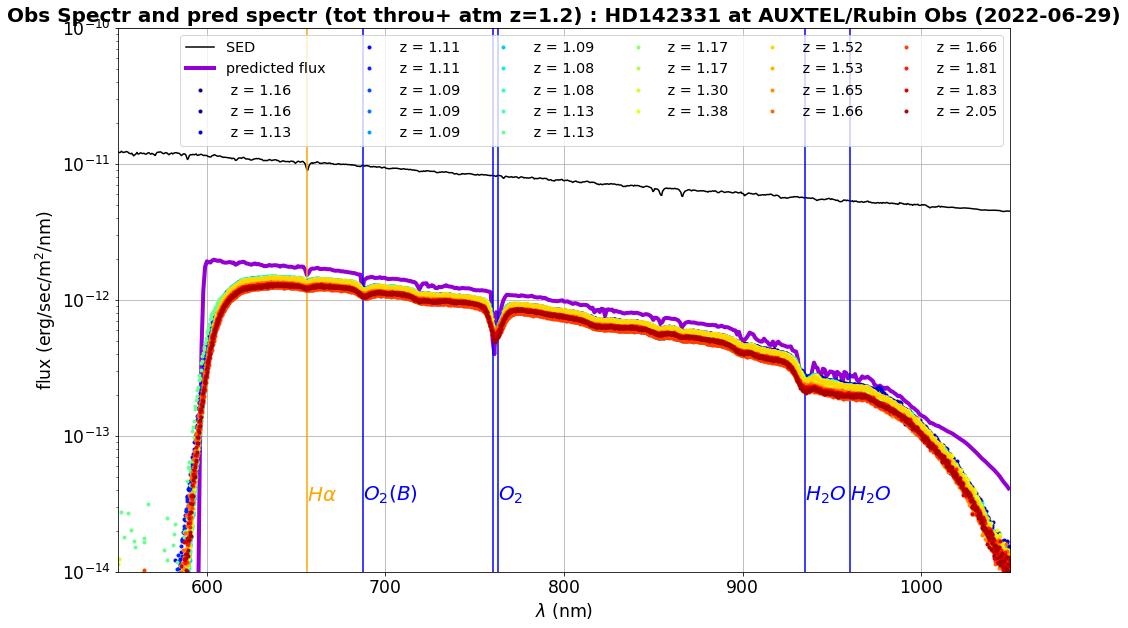

In [109]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Obs Spectr and pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=6)

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/3000)

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-pac

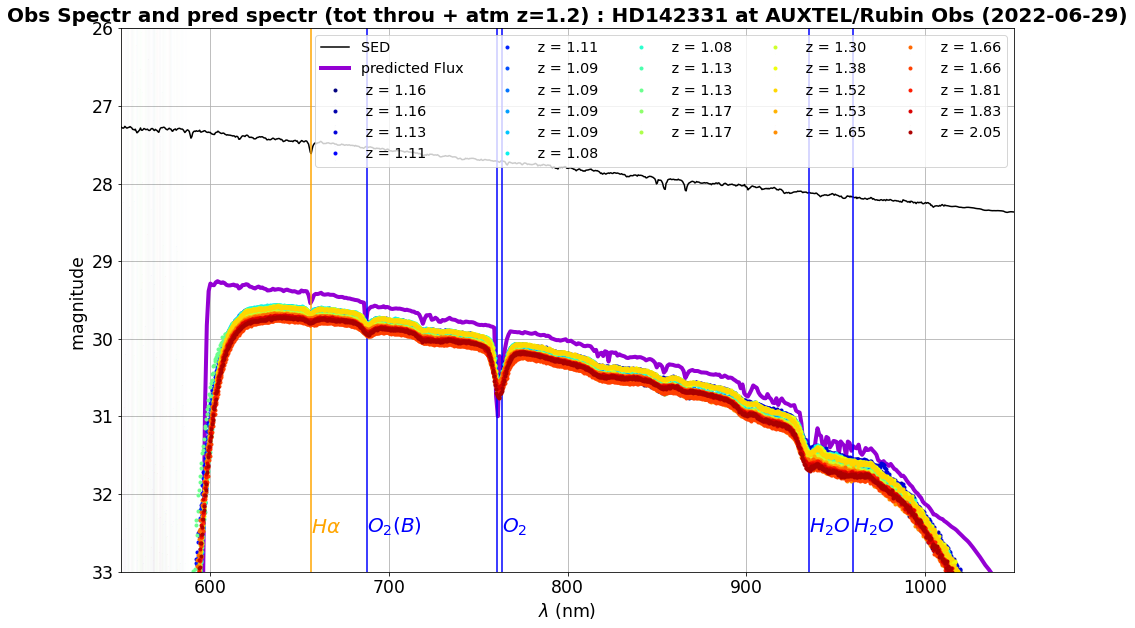

In [110]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"]/correction_area)
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Obs Spectr and pred spectr (tot throu + atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-',label = 'SED')
ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

ax.invert_yaxis()

ax.legend(loc="upper right",ncol=5)

# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)

# Filtering a line

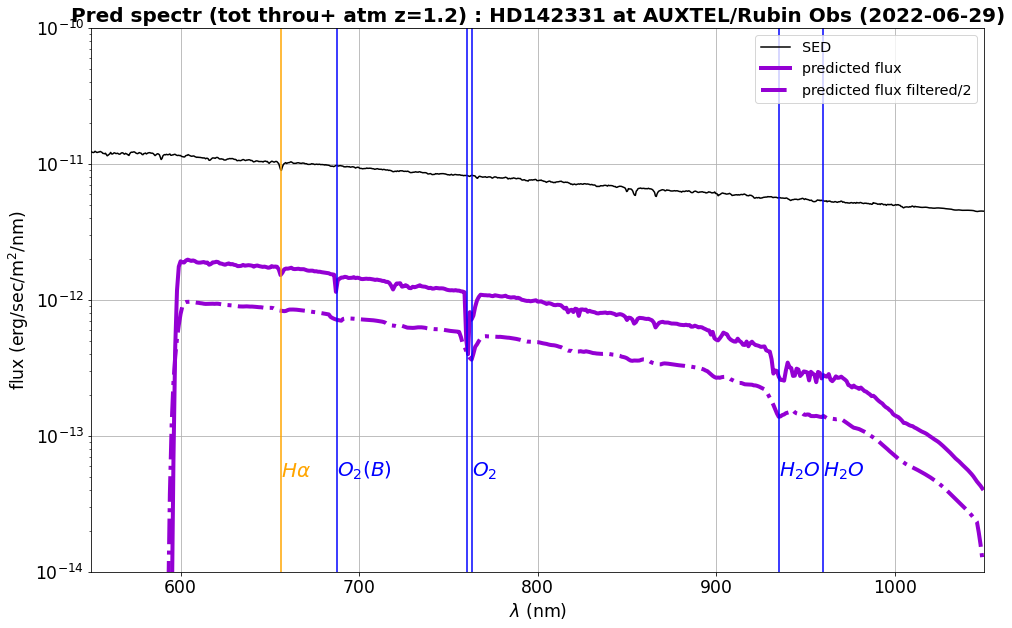

In [209]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)

# filtered flux
span = 3
sed_predicted_f_filtered = smooth_data_np_convolve(sed_predicted_f, span)
ax.plot(WL,sed_predicted_f_filtered/2,"-.",color='darkviolet',lw=4,label = "predicted flux filtered/2")


ax.set_yscale("log")
ax.legend(loc="upper right")


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2000)

## Look at lines

In [211]:
def ShowIndividualLine(lambdamin,lambdamax,fluxmin,fluxmax,thetitle):
    
    fig=plt.figure(figsize=(16,10))
    ax=fig.add_subplot(111)
    for ifile in np.arange(NBSPECTRA):
        the_df=all_spectra[ifile]
    
        airmassvalue = infos.iloc[ifile]["airmass"]
        
        num = infos.iloc[ifile]["number"]
        label_airmass = f" z = {airmassvalue:.2f} ({num})"

        #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
        ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '-', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
    title="line " + thetitle + f" :{target} at {SITE}({DATE})"
    ax.set_title(title,fontsize=20,fontweight='bold')
    #ax.plot(sed_w,sed_f,'k-',label="SED")
    ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
    ax.plot(WL,sed_predicted_f_filtered,"-",color='darkblue',lw=4,label = "predicted flux filtered")
    #ax.set_xlim(WLlineMIN  , WLlineMAX  )
    #ax.set_ylim(FLUXLIMMIN*10,FLUXLIMMAX/50)
    
    ax.set_xlim(lambdamin  , lambdamax  )
    ax.set_ylim(fluxmin,fluxmax)
    
    #ax.set_yscale("log")
    ax.legend(loc="upper right",ncol=6)

    # draw abs lines
    #plotlines(ax,ypos=FLUXLIMMAX/3000)

## O2

In [185]:
WLlineMIN = O2_1.wavelength-20
WLlineMAX = O2_1.wavelength+20

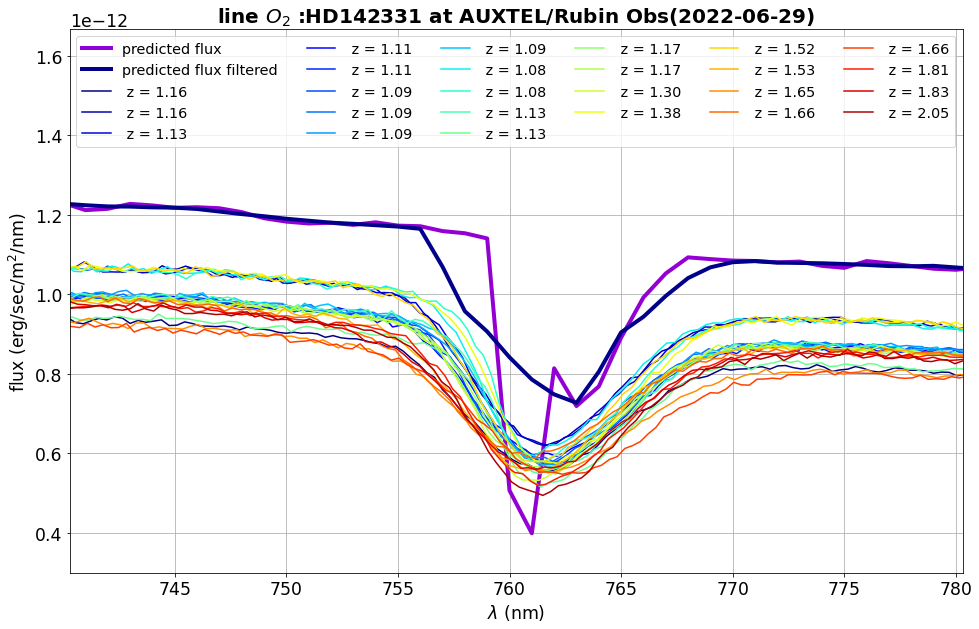

In [187]:
ShowIndividualLine(lambdamin=WLlineMIN ,lambdamax=WLlineMAX,fluxmin=FLUXLIMMIN*30,fluxmax=FLUXLIMMAX/60,thetitle=O2_1.label)

## O2B

In [189]:
WLlineMIN = O2B.wavelength-20
WLlineMAX = O2B.wavelength+20

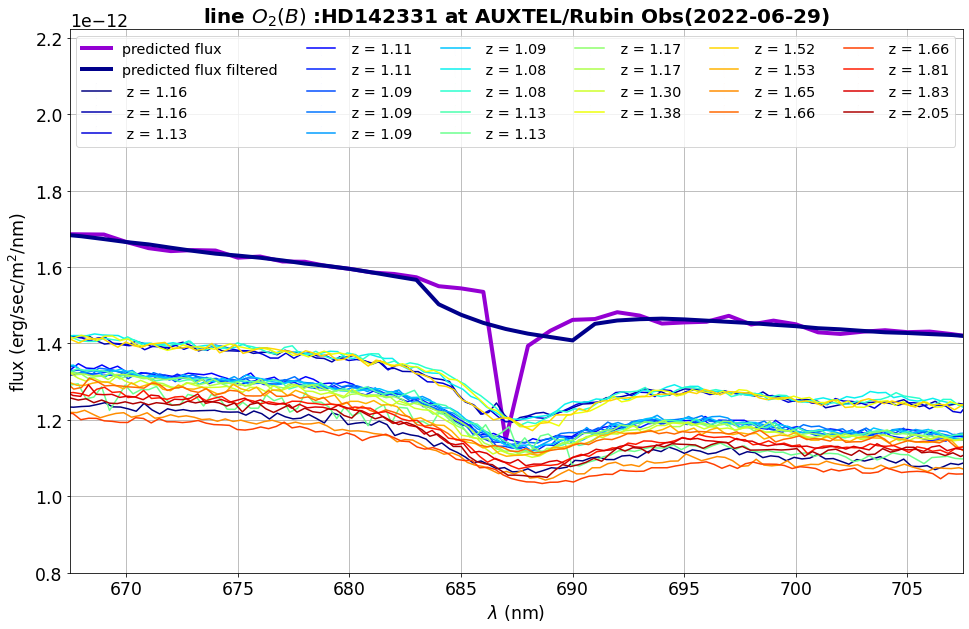

In [199]:
ShowIndividualLine(lambdamin=WLlineMIN ,lambdamax=WLlineMAX,fluxmin=FLUXLIMMIN*80,fluxmax=FLUXLIMMAX/45,thetitle=O2B.label)

## H2O

In [166]:
WLlineMIN = H2O_1.wavelength-50
WLlineMAX = H2O_2.wavelength+50

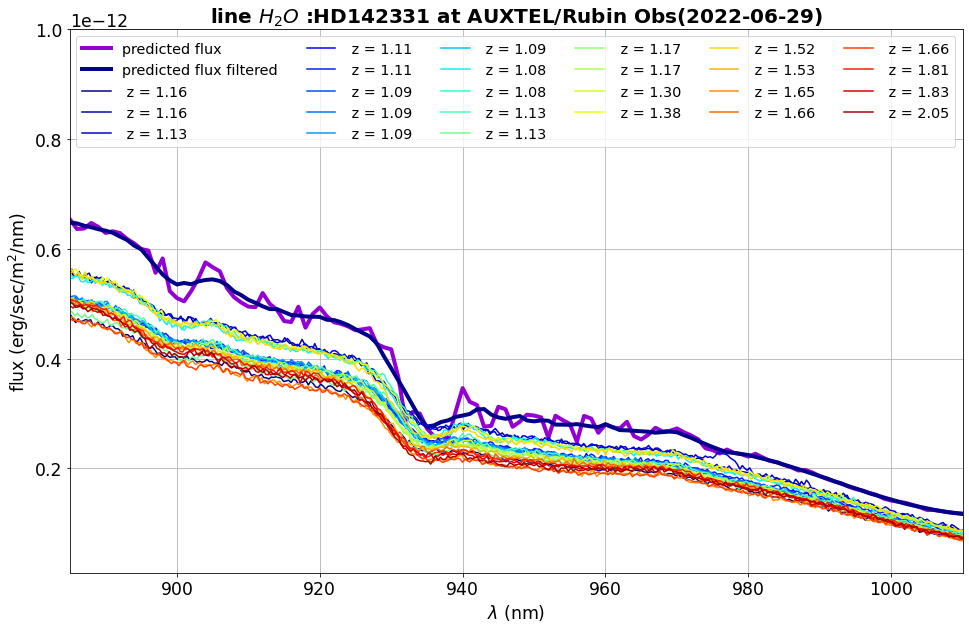

In [167]:
ShowIndividualLine(lambdamin=WLlineMIN ,lambdamax=WLlineMAX,fluxmin=FLUXLIMMIN,fluxmax=FLUXLIMMAX/100,thetitle=H2O_2.label)

## H2O

In [171]:
WLlineMIN = 700
WLlineMAX = 750

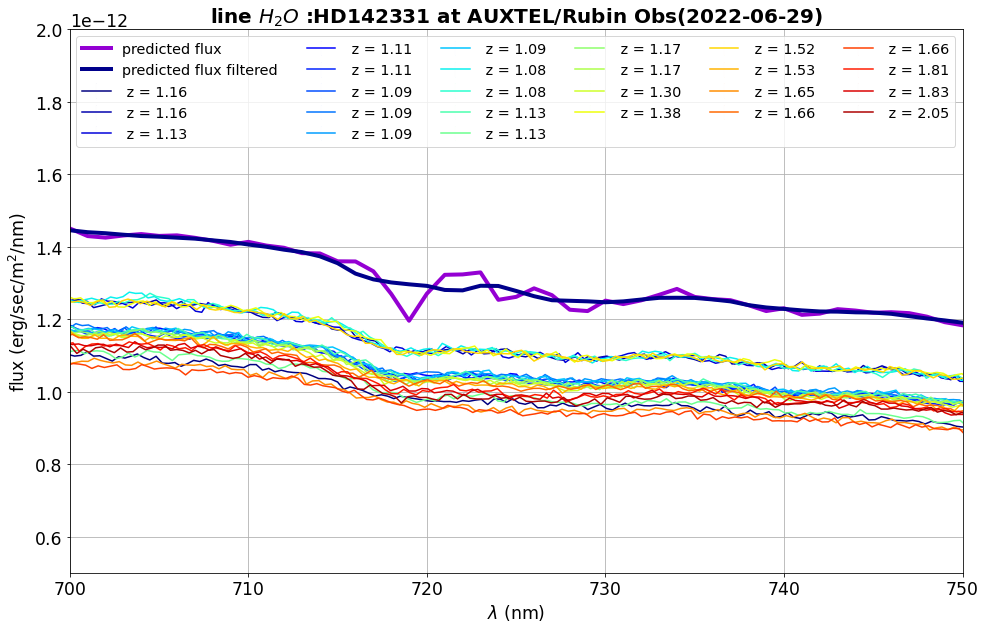

In [174]:
ShowIndividualLine(lambdamin=WLlineMIN ,lambdamax=WLlineMAX,fluxmin=FLUXLIMMIN*50,fluxmax=FLUXLIMMAX/50,thetitle=H2O_2.label)

## H2O

In [175]:
WLlineMIN = 800
WLlineMAX = 850

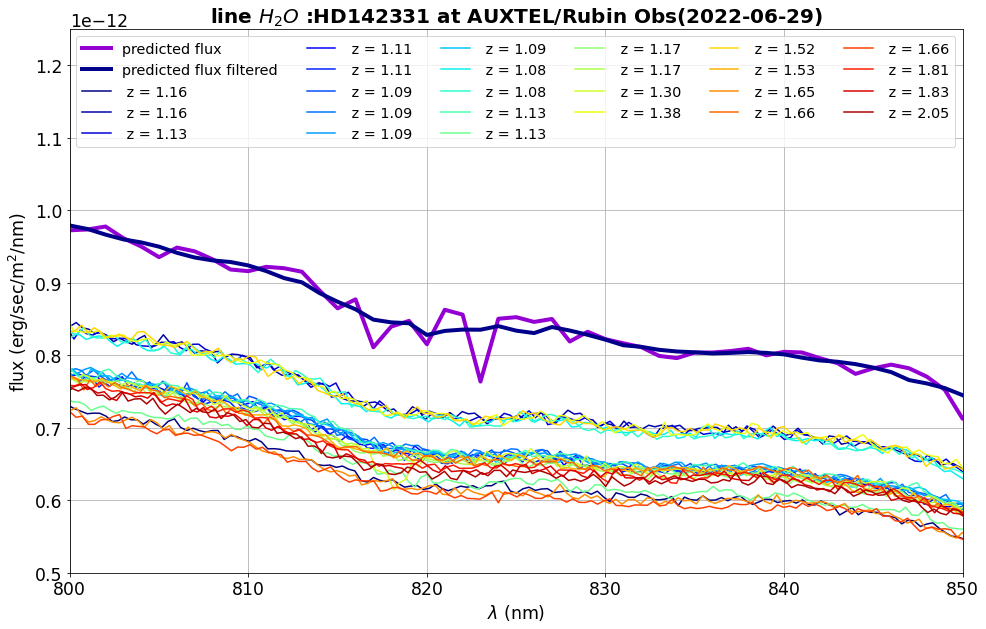

In [179]:
ShowIndividualLine(lambdamin=WLlineMIN ,lambdamax=WLlineMAX,fluxmin=FLUXLIMMIN*50,fluxmax=FLUXLIMMAX/80,thetitle=H2O_2.label)

# Ratio

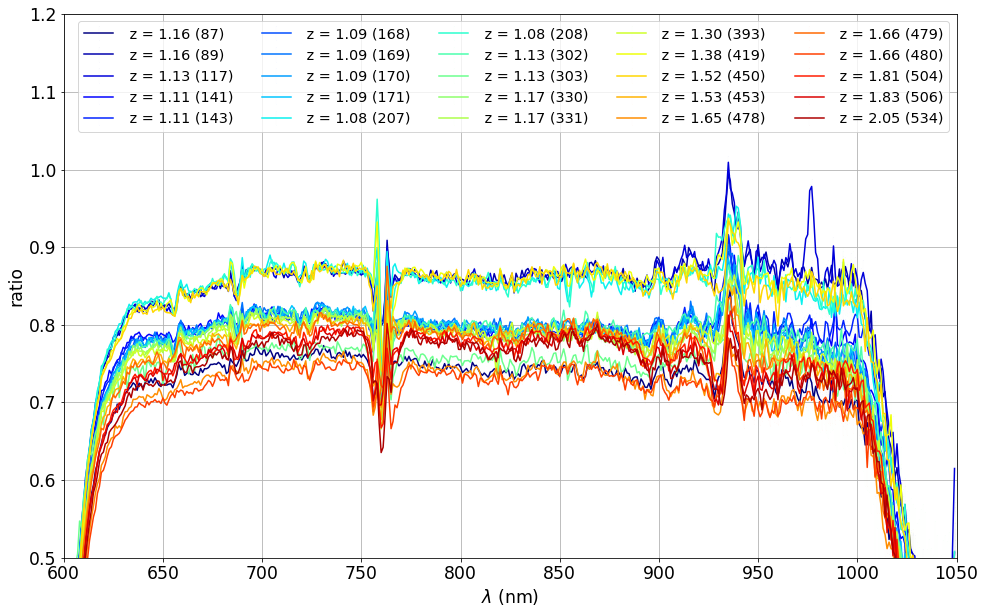

In [218]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
    
    x=the_df["all_lambdas"]
    y=the_df['all_fluxes']/correction_area, 
    yerr=the_df["all_fluxes_err"]
    
    
    f = interpolate.interp1d(x, y)
    fe = interpolate.interp1d(x, yerr)
    y_interp =f(WL)[0]
    ey_interp = fe(WL)[0]
    
    
    ratio = y_interp/sed_predicted_f_filtered
    eratio = ey_interp/sed_predicted_f_filtered
    

    #if num == 87 or num == 330 or num == 331:
    ax.errorbar(WL,ratio,yerr=eratio, fmt = '-', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)

ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Obs Spectr and pred spectr (tot throu + atm z=1.2) : {target} at {SITE} ({DATE})"
#ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim(600  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.5,1.2)
ax.legend(loc="upper right",ncol=5)

In [ ]:
assert False

# Read the output of MLfit_bouguer_linearfit.ipynb

In [ ]:
# Save CSV file
dfin = pd.read_csv(inputfile_linearfit,index_col=0) 

In [ ]:
dfin

In [ ]:
sed_predictedtoa_f = f_sed(WL) * f_thr(WL) 
sed_predictedtoa_m = -2.5*np.log10(sed_predictedtoa_f) 

In [ ]:
wl=dfin["wavelength"]
fl=dfin["sedtoa"]
flerr=dfin["errsedtoa"]

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
ax.plot(sed_w,sed_f,'k',label="SED",lw=2)
ax.plot(WL,sed_predictedtoa_f ,'b',label="predicted SED at TOA",lw=2)
ax.errorbar(wl,fl/correction_area,yerr=flerr,color="r",ecolor="pink",label="Extrapolated spectrum above atm",lw=2)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")

title=f"Pred spectr (tot throu + atm z=1.2) at TOA : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.set_ylim(0,2e-10)

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
ax.plot(sed_w,sed_f,'k',label="SED",lw=2)
ax.plot(WL,sed_predictedtoa_f ,'b',label="predicted SED at TOA",lw=2)
ax.errorbar(wl,fl/correction_area,yerr=flerr,color="r",ecolor="pink",label="Extrapolated spectrum above atm",lw=2)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")

title=f"Pred spectr (tot throu + atm z=1.2) at TOA : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.set_ylim(1e-12,1e-9)
ax.set_yscale("log")